# Latent Space and VAEs Demo

"Esta arquitectura VAE (Autoencoder Variacional) comprime un dígito de MNIST de 28x28 (784 píxeles) en una variable latente bidimensional $z = [z_1, z_2]$ utilizando el codificador (encoder).El codificador genera una media ($\mu$) y una varianza ($\sigma$) para una distribución gaussiana, y la variable latente se obtiene mediante el truco de reparametrización ($z = \mu + \epsilon \cdot \sigma$, donde $\epsilon \sim \mathcal{N}(0, 1)$).El decodificador (decoder) reconstruye la imagen a partir de $z$ o genera nuevas imágenes mediante el muestreo de nuevos puntos en el espacio latente."

In [2]:
pip install torch

In [3]:
pip install torchvision

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.99MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 158kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.93MB/s]


Epoch 1, Loss: 184.5295
Epoch 2, Loss: 160.9597
Epoch 3, Loss: 155.1208
Epoch 4, Loss: 151.3843
Epoch 5, Loss: 148.8113


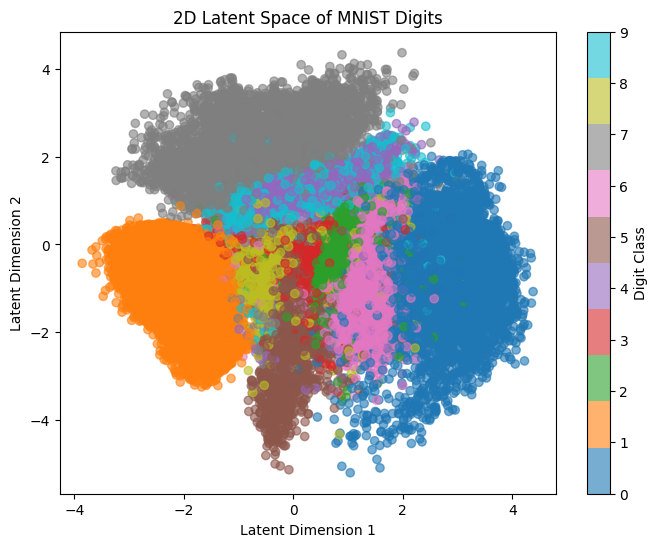

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=3):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training function
def train_vae(model, data_loader, epochs=15, device='cpu'):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(data_loader.dataset):.4f}')

# Visualization function
def plot_latent_space(model, data_loader, device='cpu'):
    model.eval()
    latent_points = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            latent_points.append(mu.cpu().numpy())
            labels.append(target.numpy())
    latent_points = np.concatenate(latent_points, axis=0)
    labels = np.concatenate(labels, axis=0)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_points[:, 0], latent_points[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Digit Class')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('2D Latent Space of MNIST Digits')
    plt.show()

# Main execution
def main():
    # Device
    device = torch.device('cpu')  # Pyodide runs on CPU in browser

    # Load MNIST dataset (subset for simplicity)
    transform = transforms.Compose([transforms.ToTensor()])
    try:
        dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
    except:
        # Fallback: synthetic data if MNIST download fails in Pyodide
        print("MNIST download unavailable, using synthetic data")
        data = torch.rand(1000, 1, 28, 28)  # Random 28x28 images
        labels = torch.randint(0, 10, (1000,))
        dataset = torch.utils.data.TensorDataset(data, labels)

    data_loader = DataLoader(dataset, batch_size=128, shuffle=True)

    # Initialize and train VAE
    model = VAE().to(device)
    train_vae(model, data_loader, epochs=5)

    # Plot latent space
    plot_latent_space(model, data_loader, device)

if __name__ == "__main__":
    main()

## Latent Space Visualization

El gráfico de dispersión muestra las variables latentes en 2D para un lote de dígitos de MNIST, coloreados según su clase (0–9). Se pueden observar grupos o clusters (por ejemplo, todos los '1' agrupados), lo que demuestra que el espacio latente organiza los puntos de datos similares en áreas cercanas entre sí.



* Variables Latentes: Cada punto en el gráfico de dispersión es una variable latente $z$, que captura la esencia de un dígito (por ejemplo, su forma o estilo) usando solo dos números.

* Espacio Latente: El gráfico 2D representa el espacio latente, donde cada punto corresponde a un posible dígito. Desplazarse por este espacio cambia la apariencia del dígito generado.

* Poder Generativo: Al muestrear nuevos puntos (por ejemplo, $z=[0.5, -0.3]$), el VAE puede generar nuevos dígitos, demostrando cómo la IA generativa crea contenido.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training function
def train_vae(model, data_loader, epochs=15, device='cpu'):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(data_loader.dataset):.4f}')

# Visualize latent space
def plot_latent_space(model, data_loader, device='cpu'):
    model.eval()
    latent_points = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            latent_points.append(mu.cpu().numpy())
            labels.append(target.numpy())
    latent_points = np.concatenate(latent_points, axis=0)
    labels = np.concatenate(labels, axis=0)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_points[:, 0], latent_points[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Digit Class')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('2D Latent Space of MNIST Digits')
    plt.show()

# Generate images from random latent variables
def generate_images(model, num_images=10, latent_dim=2, device='cpu'):
    model.eval()
    with torch.no_grad():
        # Sample random points from a standard normal distribution
        z = torch.randn(num_images, latent_dim).to(device)
        generated = model.decode(z).cpu().numpy()

    # Plot generated images
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle('Generated Images from Random Latent Points')
    plt.show()

# Interpolate between two digits
def interpolate_images(model, data_loader, digit1=3, digit2=5, steps=10, device='cpu'):
    model.eval()
    # Find one example of each digit
    z1, z2 = None, None
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            for i, label in enumerate(target):
                if label == digit1 and z1 is None:
                    z1 = mu[i:i+1]
                if label == digit2 and z2 is None:
                    z2 = mu[i:i+1]
                if z1 is not None and z2 is not None:
                    break
            if z1 is not None and z2 is not None:
                break

    # Linear interpolation between z1 and z2
    alphas = np.linspace(0, 1, steps)
    interpolated_z = torch.zeros(steps, z1.shape[1]).to(device)
    for i, alpha in enumerate(alphas):
        interpolated_z[i] = (1 - alpha) * z1 + alpha * z2

    # Generate images from interpolated points
    with torch.no_grad():
        generated = model.decode(interpolated_z).cpu().numpy()

    # Plot interpolated images
    plt.figure(figsize=(10, 2))
    for i in range(steps):
        plt.subplot(1, steps, i + 1)
        plt.imshow(generated[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f'α={alphas[i]:.2f}')
    plt.suptitle(f'Interpolation from Digit {digit1} to Digit {digit2}')
    plt.show()

# Main execution
def main():
    # Device
    device = torch.device('cpu')  # runs on CPU

    # Load MNIST dataset (subset for simplicity)
    transform = transforms.Compose([transforms.ToTensor()])
    try:
        dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
    except:
        # Fallback: synthetic data if MNIST download fails
        print("MNIST download unavailable, using synthetic data")
        data = torch.rand(1000, 1, 28, 28)  # Random 28x28 images
        labels = torch.randint(0, 10, (1000,))
        dataset = torch.utils.data.TensorDataset(data, labels)

    data_loader = DataLoader(dataset, batch_size=128, shuffle=True)

    # Initialize and train VAE
    model = VAE().to(device)
    train_vae(model, data_loader, epochs=15)

    # Plot latent space
    plot_latent_space(model, data_loader, device)

    # Generate random images
    generate_images(model, num_images=10, latent_dim=2, device=device)

    # Cambia esta línea en tu función main():
    interpolate_images(model, data_loader, digit1=1, digit2=7, steps=10, device=device)

if __name__ == "__main__":
    main()

Epoch 1, Loss: 185.5893
Epoch 2, Loss: 161.8353
Epoch 3, Loss: 155.0504
Epoch 4, Loss: 151.4971
Epoch 5, Loss: 149.2145
Epoch 6, Loss: 147.3545
Epoch 7, Loss: 146.0626
Epoch 8, Loss: 144.9373


### Questions

Responde las siguientes preguntas:

¿Por qué graficar en 2 dimensiones?

* R// Se grafica en 2 dimensiones porque permite interpretar visualmente cómo el modelo organiza la información. Los seres humanos no podemos visualizar espacios de 4, 10 o 100 dimensiones. Al forzar al modelo a comprimir la información en un plano 2D (latent_dim=2), podemos ver si el modelo ha aprendido a agrupar dígitos similares (clústeres) y separar los diferentes.



¿Qué sucede cuando aumentan las épocas (epochs) en el modelo 1 frente al modelo 2?

* R// Al inicio (Épocas 1-5): El aprendizaje es rápido. La pérdida cae drásticamente (de 188 a 150) porque el modelo está aprendiendo las formas básicas (círculos, líneas).

* Al final (Épocas 10-15): El aprendizaje se estabiliza. La mejora es más lenta (de 144 a 142), perfeccionando detalles finos y bordes de los números.



Realiza una transformación (morph) entre los números 1 y 7 en cualquier modelo y comenta los resultados.

¿Qué modelo obtuvo mejores resultados: el de 5 o el de 15 épocas?

* La pérdida (Loss) en la época 5 fue de 150.09, mientras que en la época 15 bajó a 142.06.


Crea un modelo con 3 variables latentes. ¿Cuál es el resultado?
   